In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

$f(x) = 3x^2-4x+5$

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

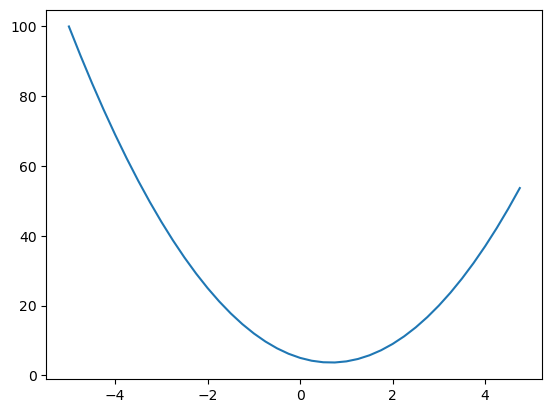

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# partial derivative of d in respect to a
d1 = a*b + c
a += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [80]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
d

Value(data=4.0)

In [7]:
print(d._prev)
print(d._op)

{Value(data=10.0), Value(data=-6.0)}
+


In [81]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

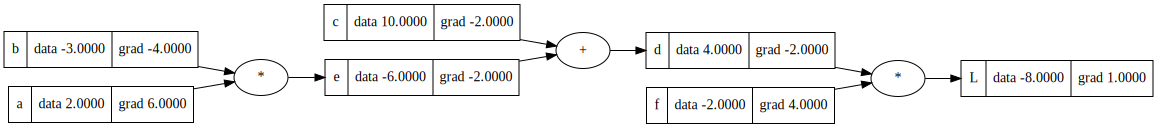

In [33]:
draw_dot(L)

$d = c + e$

$\frac{\partial d}{\partial c} = 1$
 
$\frac{\partial L}{\partial d} = f = -2$

$\frac{\partial c}{\partial a} = b = -3$

$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial d}\cdot\frac{\partial d}{\partial c}\cdot\frac{\partial c}{\partial a} = -2\cdot1\cdot-3=6$


In [32]:
# Backprop by hand

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [25]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000000227


In [82]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w2')
w2 = Value(1.0, label='w1')

# bias of the neuron
b = Value(6.881373587, label='b')


# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

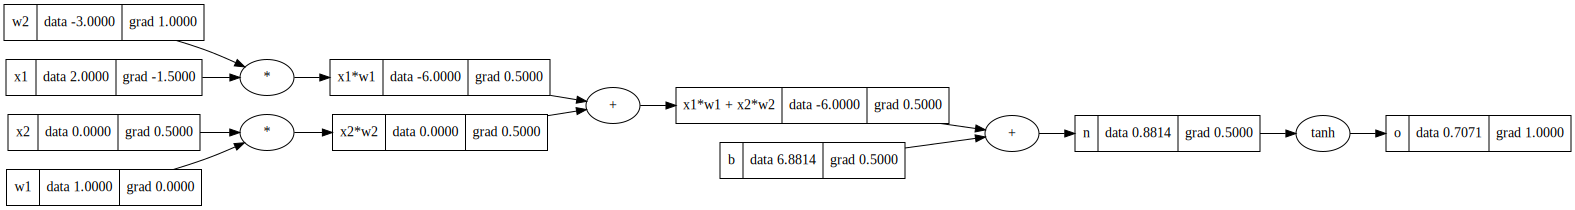

In [85]:
draw_dot(o)

In [84]:
# Automatic back prop in function
o.backward()

In [70]:
# Calling backwards manually
o.grad = 1
o._backward() 
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [54]:
# Calculating backprop manually
o.grad = 1.0
n.grad = 0.5 # 1 - o.data**2
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = -1.5
w1.grad = 1
x2.grad = 0.5
w2.grad = 0.0


In [78]:
# Automatic back prop
o.grad = 1.0

# Build topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()